# CLIP: Contrastive Language Image Pre-training Inference Demo

This example shows the usage of a pre-trained CLIP with ViT-B/16 as an image encoder for the task of zero-shot image classification. 

## Create the model
Creating a model is simple. You need a configuration file and the path to the pre-trained weights. Below is an example code snippet

In [13]:
from corenet.options.opts import get_training_arguments
from corenet.modeling import get_model
from PIL import Image
import torch
import os
from torchvision.transforms import Compose, Resize, PILToTensor, CenterCrop
from corenet.data.text_tokenizer import build_tokenizer


# configuration file path
config_file = os.path.join(
    os.getcwd(), "..", "projects/range_augment/clip/clip_vit_base.yaml"
)
# pre-trained weights
pretrained_weights = "https://docs-assets.developer.apple.com/ml-research/models/cvnets-v2/examples/range_augment/clip/clip_vit_base_16.pt"

opts = get_training_arguments(
    args=[
        "--common.config-file",
        config_file,
        "--model.multi-modal-image-text.pretrained",
        pretrained_weights,
    ]
)

# build the model
model = get_model(opts)
# set the model in evaluation mode.
model.eval()

2024-04-15 11:41:15 - INFO    - Trainable parameters: ['cls_token', 'neural_augmentor.brightness._low', 'neural_augmentor.brightness._high', 'neural_augmentor.contrast._low', 'neural_augmentor.contrast._high', 'neural_augmentor.noise._low', 'neural_augmentor.noise._high', 'patch_emb.0.block.conv.weight', 'patch_emb.0.block.norm.weight', 'patch_emb.0.block.norm.bias', 'patch_emb.1.block.conv.weight', 'patch_emb.1.block.norm.weight', 'patch_emb.1.block.norm.bias', 'patch_emb.2.block.conv.weight', 'patch_emb.2.block.conv.bias', 'post_transformer_norm.weight', 'post_transformer_norm.bias', 'transformer.0.pre_norm_mha.0.weight', 'transformer.0.pre_norm_mha.0.bias', 'transformer.0.pre_norm_mha.1.qkv_proj.weight', 'transformer.0.pre_norm_mha.1.qkv_proj.bias', 'transformer.0.pre_norm_mha.1.out_proj.weight', 'transformer.0.pre_norm_mha.1.out_proj.bias', 'transformer.0.pre_norm_ffn.0.weight', 'transformer.0.pre_norm_ffn.0.bias', 'transformer.0.pre_norm_ffn.1.weight', 'transformer.0.pre_norm_ffn.

CLIP(
  (image_encoder): VisionTransformer(
    (neural_augmentor): DistributionNeuralAugmentor(
    	Brightness=UniformSampler(min_fn=Clip(min=0.1, max=0.9, clipping=soft), max_fn=Clip(min=1.1, max=10.0, clipping=soft)), 
    	Contrast=UniformSampler(min_fn=Clip(min=0.1, max=0.9, clipping=soft), max_fn=Clip(min=1.1, max=10.0, clipping=soft)), 
    	Noise=UniformSampler(min_fn=Clip(min=0.0, max=5e-05, clipping=soft), max_fn=Clip(min=0.0001, max=1.0, clipping=soft)), )
    (patch_emb): Sequential(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False, normalization=BatchNorm2d, activation=GELU)
      (1): Conv2d(192, 192, kernel_size=(2, 2), stride=(2, 2), bias=False, normalization=BatchNorm2d, activation=GELU)
      (2): Conv2d(192, 768, kernel_size=(2, 2), stride=(2, 2))
    )
    (post_transformer_norm): LayerNormFP32((768,), eps=1e-06, elementwise_affine=True)
    (transformer): Sequential(
      (0): TransformerEncoder(embed_dim=768, ffn_dim=3072, 

## Zero-shot classification using CLIP

Zero-shot classification involves following steps:

1. ***Choose Textual Description:*** Select the textual description that represents the class we want to classify images into. This could be a simple phrase or a sentence describing the class. For example, if we want to classify images of dogs, the textual description could be "a photo of a dog".
2. ***Encode Textual Description:*** Use CLIP's text encoder to convert the textual description into a vector representation. This is done by passing the textual description through the text encoder of the CLIP model.
3. ***Encode Image:*** Similar to text encoder, encode the image we want to classify using CLIP's image encoder. This involves passing the image through the image encoder of the CLIP model.
4. ***Compute Similarity Score:*** Calculate the similarity score between the encoded image and the encoded textual description. This is typically done by taking a dot-product between image embeddings and text embeddings.
5. ***Classify Image:*** The similarity score obtained in the previous step represents how well the image matches the textual description. Higher similarity scores indicate a stronger association between the image and the textual description. We can take an argmax to identify the class corresponding to the input image.

In [14]:
# build the text tokenizer. It is useful to convert the text description into tokens.
text_tokenizer = build_tokenizer(opts)

## STEP 1: Choose Textual description

example_class_names = ["cat", "horse", "dog"]
input_text_templates = [
    "a photo of a {}".format(class_name) for class_name in example_class_names
]
# Context length is 7 because we have 5 words in text template + beginning of text token + end of text token
context_length = 7

tokenized_input_templates = [
    text_tokenizer(inp_template) for inp_template in input_text_templates
]
# The size of tokenized_input_templates after stacking would be [num_classes, context_length]. In this case,
# num_classes=3 (cat, horse, dog) and context_length=7
tokenized_input_templates = torch.stack(tokenized_input_templates, dim=0)
tokenized_input_templates.shape

torch.Size([3, 7])

In [15]:
## STEP 2: Encode Textual description

# The expected input to text encoder is [batch_size, num_classes, num_captions, context_length]
# For this example, we have batch_size=1 and num_captions=1.
# So, we add dummy dimensions to tokenized_input_templates to convert its shape from [num_classes, context_length] to [batch_size, num_classes, num_captions, context_length]

tokenized_input_templates = tokenized_input_templates[None, :, None, :]

# produce text_embeddings
with torch.no_grad():
    text_embeddings = model.text_encoder(tokenized_input_templates)
# The shape of text embeddings is [hidden_dim, num_classes]
text_embeddings.shape

torch.Size([512, 3])

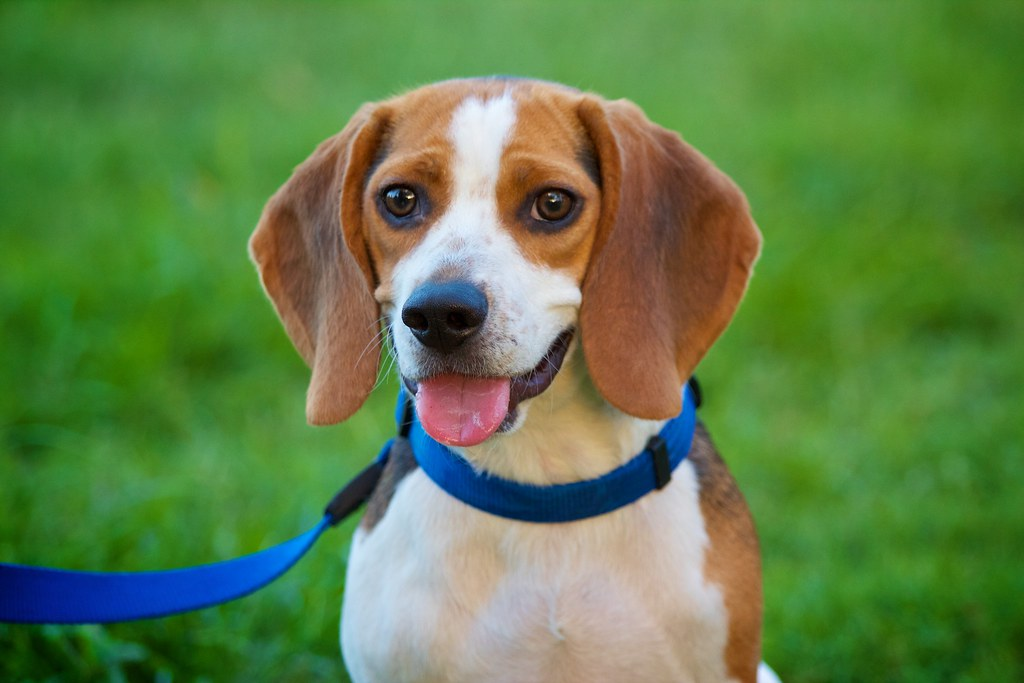

In [16]:
## STEP 3: Encode image

## STEP 3.1: Read an image
img_path = os.path.join(os.getcwd(), "..", "assets", "dog.jpeg")
image = Image.open(img_path).convert("RGB")
image

In [17]:
## STEP 3.2: Transform an image
# The model is pre-trained using 224x224 resolution. Therefore, we resize the input PIL image while maintaining an aspect ratio,
# such that shorter dimension is 224. We then crop 224x224 image from the center. After that, we convert the resized PIL image into a tensor.
# The values in tensor range between 0 and 255. We covert it to float and normalize it between 0.0 and 1.0 by dividing the tensor by 255.

img_transforms = Compose([Resize(size=224), CenterCrop(size=224), PILToTensor()])

# Transform the image and normalize it between 0 and 1
input_img_tensor = img_transforms(image)
input_img_tensor = input_img_tensor.to(torch.float).div(255.0)

# add dummy batch dimension
input_img_tensor = input_img_tensor[None, ...]
input_img_tensor.shape

torch.Size([1, 3, 224, 224])

In [18]:
## STEP 3.3 Encode an image
with torch.no_grad():
    image_embeddings = model.image_encoder(input_img_tensor)["logits"]
# the shape of image_embeddings is [batch_size, hidden_dim]
image_embeddings.shape

torch.Size([1, 512])

In [19]:
## STEP 4: Compute similarity score

# Compute a dot product between image and text  embeddings
# [batch_size, hidden_dim] x [hidden_dim, num_classes] --> [batch_size, num_classes]
similarity_score = image_embeddings @ text_embeddings
similarity_score.shape

torch.Size([1, 3])

In [20]:
## STEP 5: Clasify image

predicted_class_prob, predicted_class_id = torch.max(similarity_score, dim=-1)
n_samples = predicted_class_prob.shape[0]
for batch_id in range(n_samples):
    print(
        f"Predicted class for sample {batch_id} is {example_class_names[predicted_class_id[batch_id]]} (p={predicted_class_prob[batch_id]:.2f})"
    )

Predicted class for sample 0 is dog (p=0.37)
